In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense



In [2]:
train_dir = 'data3a/training'
val_dir = 'data3a/validation'

In [3]:
img_width, img_height = 150, 150

In [4]:
epoch = 50
batch_size=16

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [7]:
vgg19_model = Sequential()
pretrained_model = VGG19(
    include_top=False,
    input_shape=(img_width, img_height, 3),
    pooling='max',
    classes=3,
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable=False
    
vgg19_model.add(pretrained_model)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(512, activation='relu'))
# minor moderate and severe (3)
vgg19_model.add(Dense(3, activation='softmax'))

In [8]:
vgg19_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [9]:
#Model compile
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import CSVLogger

# Define the CSVLogger

log_folder = "traininglog"
log_file_path = f"{log_folder}/vgg19_training_log.csv"

csv_logger = CSVLogger(log_file_path, append=True)

In [11]:
import time 
start_time = time.time()

#Model Train 
history = vgg19_model.fit(train_generator, epochs=epoch, validation_data=val_generator,callbacks=[csv_logger])

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total training time: {elapsed_time:.2f} seconds")

Epoch 1/50
87/87 [==============================] - 85s 963ms/step - loss: 1.0463 - accuracy: 0.5047 - val_loss: 0.8076 - val_accuracy: 0.6089
Epoch 2/50
87/87 [==============================] - 84s 964ms/step - loss: 0.9133 - accuracy: 0.5459 - val_loss: 0.7665 - val_accuracy: 0.6653
Epoch 3/50
87/87 [==============================] - 84s 961ms/step - loss: 0.8712 - accuracy: 0.5806 - val_loss: 0.7595 - val_accuracy: 0.6492
Epoch 4/50
87/87 [==============================] - 83s 950ms/step - loss: 0.8485 - accuracy: 0.5871 - val_loss: 0.8452 - val_accuracy: 0.6331
Epoch 5/50
87/87 [==============================] - 84s 965ms/step - loss: 0.8562 - accuracy: 0.5770 - val_loss: 0.7618 - val_accuracy: 0.6694
Epoch 6/50
87/87 [==============================] - 82s 948ms/step - loss: 0.8409 - accuracy: 0.5987 - val_loss: 0.7625 - val_accuracy: 0.6573
Epoch 7/50
87/87 [==============================] - 84s 961ms/step - loss: 0.8202 - accuracy: 0.6298 - val_loss: 0.7638 - val_accuracy: 0.6331

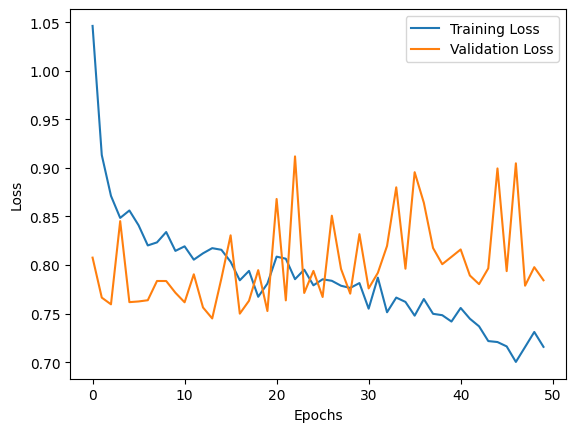

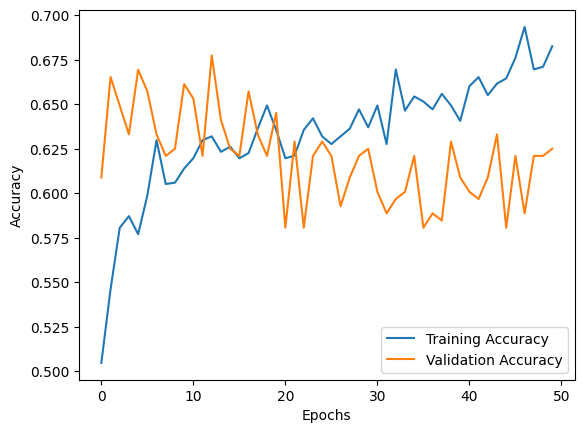

In [12]:
import matplotlib.pyplot as plt
# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
from sklearn.metrics import f1_score
# # f1 score
# plt.plot(history.history['f1_score'], label='Training F1 Score')
# plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.show()

8/8 [==============================] - 12s 1s/step
Confusion Matrix:


C:\Users\sandi\AppData\Local\Temp\ipykernel_12700\1780940576.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
C:\Users\sandi\AppData\Local\Temp\ipykernel_12700\1780940576.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])


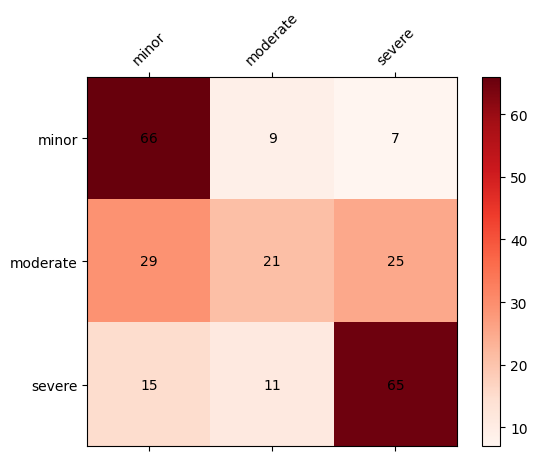

Classification Report:
              precision    recall  f1-score   support

    01-minor       0.60      0.80      0.69        82
 02-moderate       0.51      0.28      0.36        75
   03-severe       0.67      0.71      0.69        91

    accuracy                           0.61       248
   macro avg       0.59      0.60      0.58       248
weighted avg       0.60      0.61      0.59       248



In [12]:
import numpy as np
val_images, val_labels = [], []
class_names = sorted(train_generator.class_indices.keys())
for i in range(len(val_generator)):
    images, labels = val_generator[i]
    val_images.extend(images)
    val_labels.extend(np.argmax(labels, axis=1))


val_images = np.array(val_images)
val_labels = np.array(val_labels)

predictions = vgg19_model.predict(val_images)



from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(predictions, axis=1)
y_true = val_labels

confusion_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center')
print('Confusion Matrix:')

plt.show()



report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

In [13]:
vgg19_model.save('vgg19-model-bs16-ep50.keras')
print('model saved')

model saved


1/1 [==============================] - 0s 79ms/step


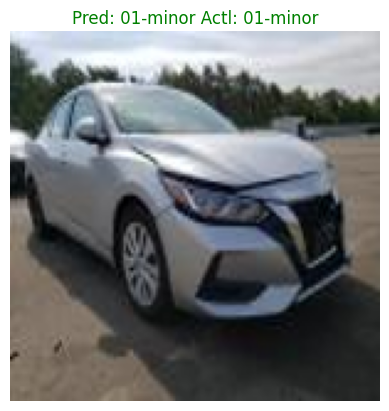

1/1 [==============================] - 0s 75ms/step


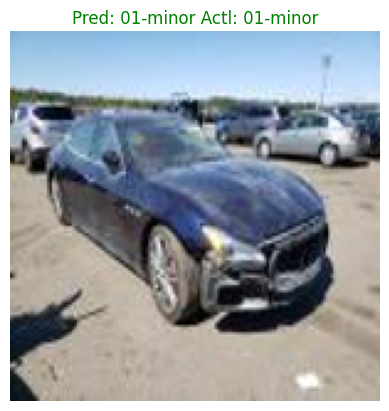

1/1 [==============================] - 0s 74ms/step


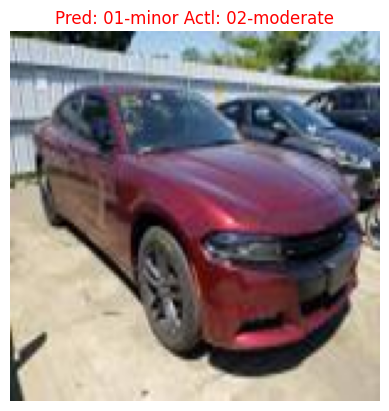

1/1 [==============================] - 0s 76ms/step


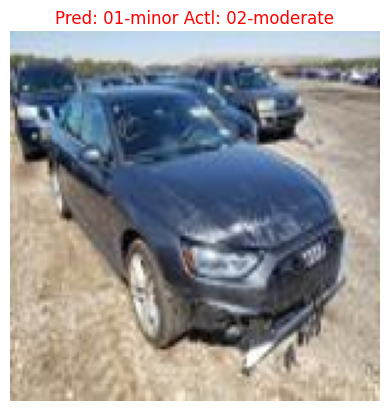

1/1 [==============================] - 0s 75ms/step


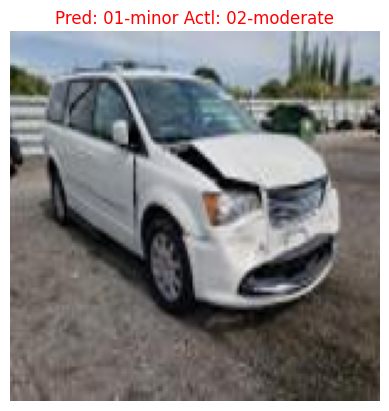

1/1 [==============================] - 0s 75ms/step


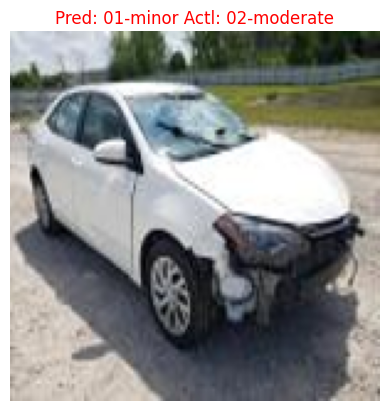

1/1 [==============================] - 0s 73ms/step


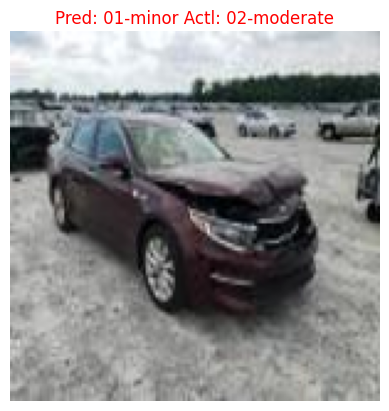

1/1 [==============================] - 0s 87ms/step


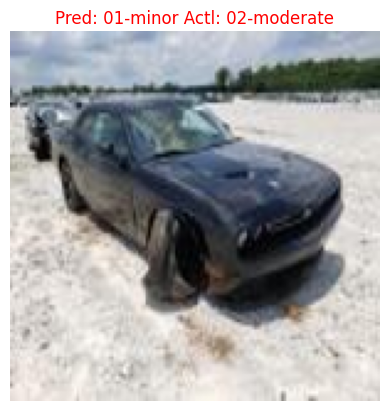

1/1 [==============================] - 0s 76ms/step


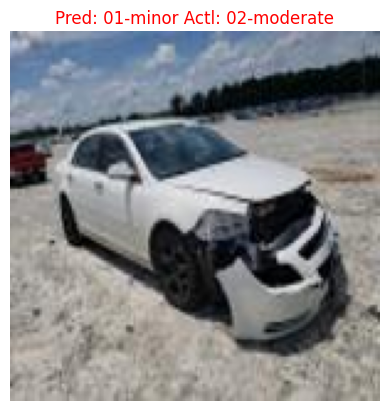

1/1 [==============================] - 0s 76ms/step


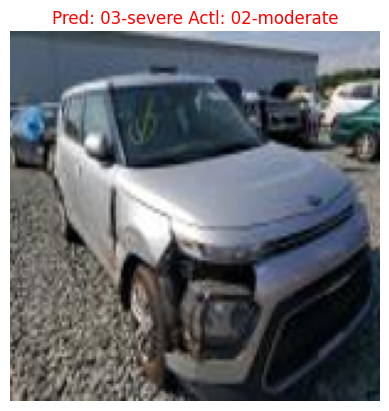

1/1 [==============================] - 0s 77ms/step


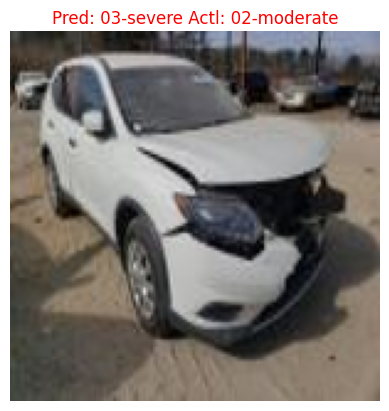

1/1 [==============================] - 0s 87ms/step


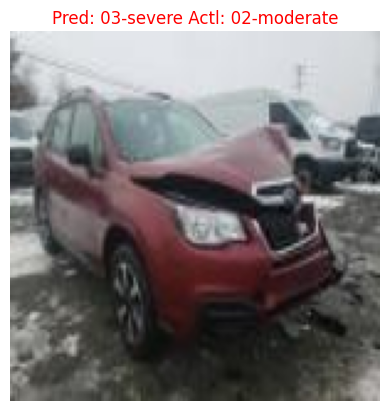

1/1 [==============================] - 0s 84ms/step


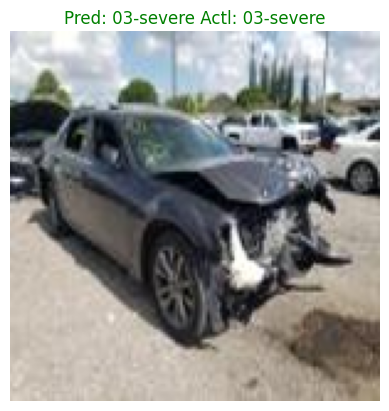

1/1 [==============================] - 0s 76ms/step


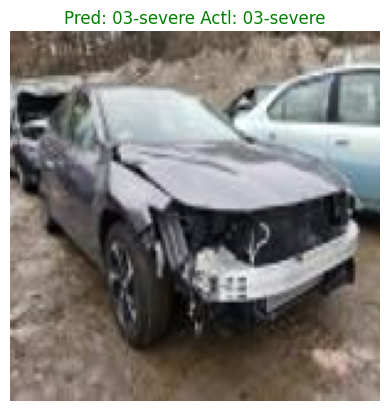

1/1 [==============================] - 0s 75ms/step


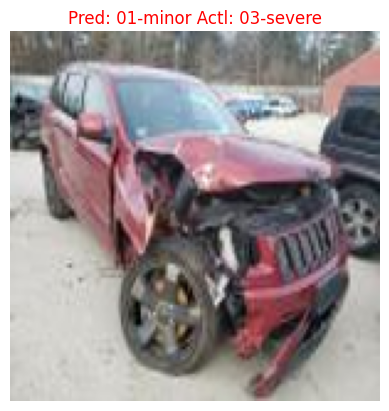

1/1 [==============================] - 0s 76ms/step


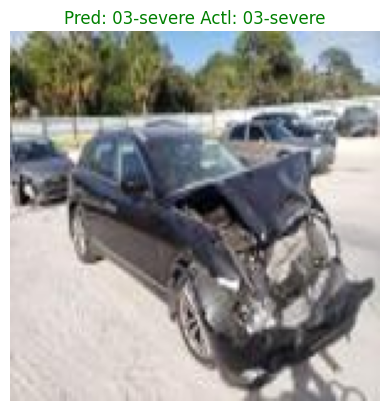

1/1 [==============================] - 0s 74ms/step


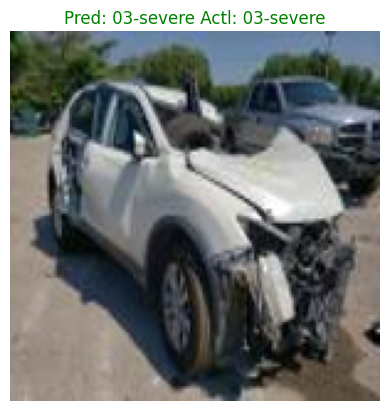

1/1 [==============================] - 0s 84ms/step


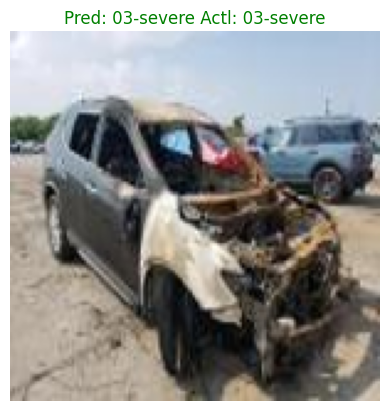

1/1 [==============================] - 0s 74ms/step


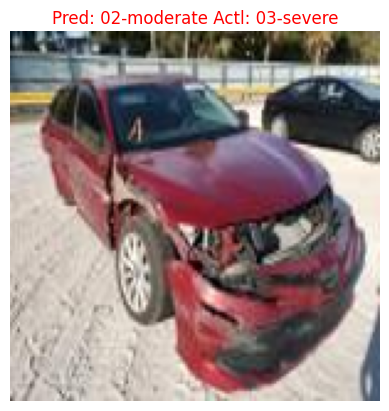

1/1 [==============================] - 0s 77ms/step


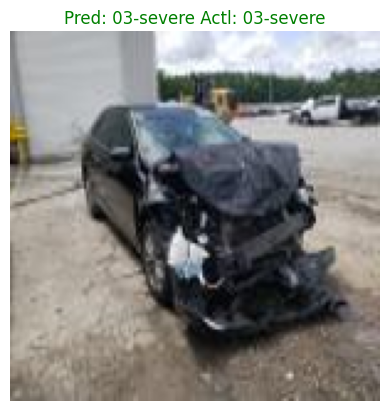

1/1 [==============================] - 0s 76ms/step


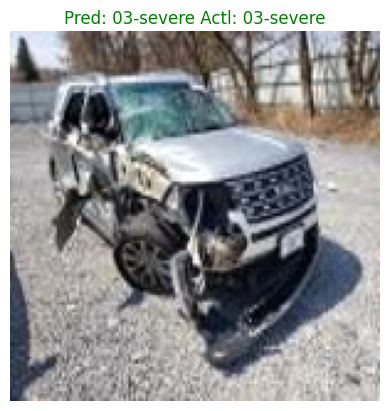

1/1 [==============================] - 0s 75ms/step


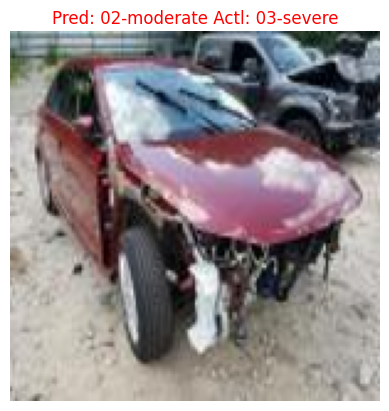

False: 13
True: 9


In [14]:
val_dir = 'data3a/validation'
class_names = ["01-minor", "02-moderate", "03-severe"]

image_paths = []
for class_name in class_names:
    folder_path = os.path.join(val_dir, class_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(folder_path, filename))
negative = 0
positive = 0
for image_path in image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = img.resize((img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)
    pred = vgg19_model.predict(img)
    pred_label = class_names[np.argmax(pred)]
    folder_name = os.path.basename(os.path.dirname(image_path))
    plt.imshow(img[0])
    if (pred_label != folder_name):
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'red')
        negative+=1
    else:
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'green')
        positive+=1
   
    plt.axis('off')
    plt.show() 
print('False: '+ str(negative) + '\nTrue: ' + str(positive))